### Recreation of Proposition 99 study - Effect of tax increase on tobacco sales in California

In [7]:
import numpy as np
import pandas as pd
from toolz import curry, partial
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

pd.set_option('display.max_columns', 10)

ImportError: DLL load failed while importing _path: Das angegebene Modul wurde nicht gefunden.

In [ ]:
data = (pd.read_csv("data/smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california": "treated"})
        .replace({"state": {3: "california"}}))

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [ ]:
data = pd.read_csv("data/smoking_data.csv")
data.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice
0,Alabama,1970.0,89.8,NaN,NaN,0.178862,39.6
1,Alabama,1971.0,95.4,NaN,NaN,0.179928,42.7
2,Alabama,1972.0,101.1,9.498476,NaN,0.180994,42.3
3,Alabama,1973.0,102.9,9.550107,NaN,0.182060,42.1
4,Alabama,1974.0,108.2,9.537163,NaN,0.183126,43.1


In [ ]:
data_piv = data.pivot("year", "state", "cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns if c != "california"})

data_piv.head()[["state_1", "state_2", "state_4", "state_38", "state_39", "california"]].round()

state,state_1,state_2,state_4,state_38,state_39,california
year,,,,,,
1970,90.0,100.0,125.0,106.0,132.0,123.0
1971,95.0,104.0,126.0,105.0,132.0,121.0
1972,101.0,104.0,134.0,109.0,140.0,124.0
1973,103.0,108.0,138.0,110.0,141.0,124.0
1974,108.0,110.0,133.0,112.0,146.0,127.0


In [ ]:
did_model = smf.ols("cigsale ~ after_treatment*treated", data=data).fit()
att = did_model.params["after_treatment[T.True]:treated[T.True]"]
print("DiD ATT: ", att.round(3))

DiD ATT:  -27.349


In [ ]:
data.query("~after_treatment")["year"].mean()

1979.0

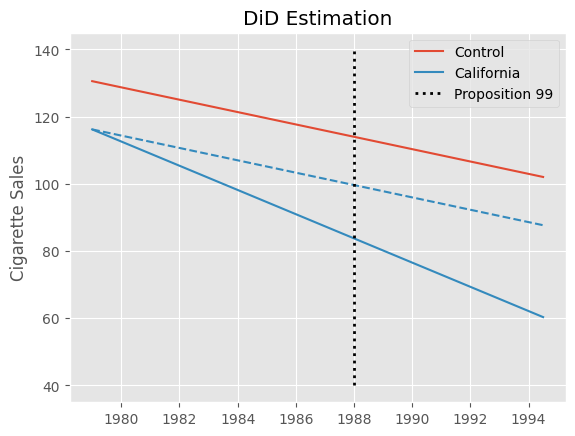

In [ ]:
pre_year = data.query("~after_treatment")["year"].mean() # tilde negates statement
post_year = data.query("after_treatment")["year"].mean()

pre_control_y = did_model.params["Intercept"]
post_control_y = did_model.params["Intercept"] + did_model.params["after_treatment[T.True]"]

pre_treat_y = did_model.params["Intercept"] + did_model.params["treated[T.True]"]

post_treat_y0 = post_control_y + did_model.params["treated[T.True]"]

post_treat_y1 = post_treat_y0 + did_model.params["after_treatment[T.True]:treated[T.True]"]

plt.plot([pre_year, post_year], [pre_control_y, post_control_y], color="C0", label="Control")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y0], color="C1", ls="dashed")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y1], color="C1", label="California")

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.title("DiD Estimation")
plt.ylabel("Cigarette Sales")
plt.legend();

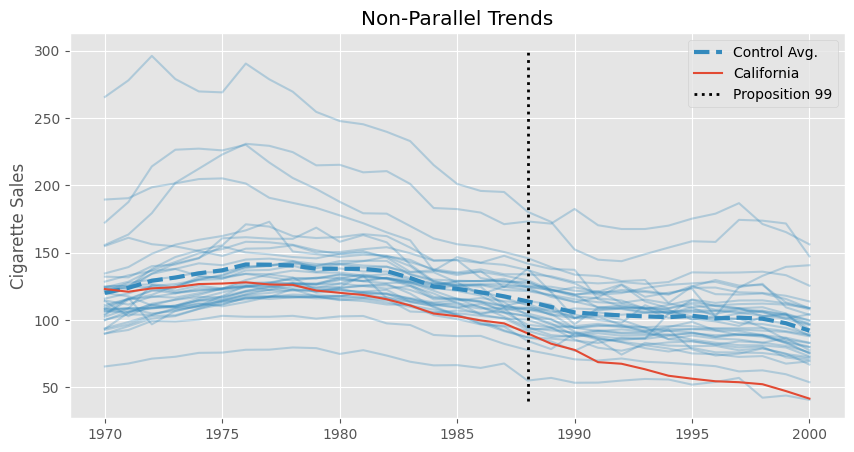

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.3)
plt.plot(data_piv.drop(columns=["california"]).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Non-Parallel Trends");

In [ ]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("state")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""cigsale ~ treat"""
mod = smf.ols(formula,
              data=data
              .assign(treat = data["after_treatment"]*data["treated"])
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="cigsale")))

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-119.1647,0.333,-358.379,0.000,-119.817,-118.512
treat,-27.3491,4.283,-6.385,0.000,-35.753,-18.945


In [ ]:
#Import packages
import pandas as pd
from SyntheticControlMethods import Synth

#Import data
df = pd.read_csv("Data/german_reunification.csv")
df = df.drop(columns="code", axis=1)

df.head()

,country,year,gdp,infrate,trade,schooling,invest60,invest70,invest80,industry
0,USA,1960,2879,NaN,9.693181,43.799999,NaN,NaN,NaN,NaN
1,USA,1961,2929,1.075182,9.444655,NaN,NaN,NaN,NaN,NaN
2,USA,1962,3103,1.116071,9.429324,NaN,NaN,NaN,NaN,NaN
3,USA,1963,3227,1.214128,9.470706,NaN,NaN,NaN,NaN,NaN
4,USA,1964,3420,1.308615,9.725879,NaN,NaN,NaN,NaN,NaN


In [40]:
from sc import SyntheticControl

sc_model = SyntheticControl()

y_co_pre = data.query("~after_treatment").query("~treated").pivot("year", "state", "cigsale")
y_tr_pre = data.query("~after_treatment").query("treated")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")

sc = data.query("~treated").pivot("year", "state", "cigsale").dot(sc_weights)

att = data.query("treated")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT: ", att.round(4))

TypeError: Invalid comparison between dtype=int64 and str

---

## Synthetic DiD

In [52]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        # pivot the data to the (T_pre, N_co) matrix representation
        y_pre = (control
                 .query(f"~{post_col}")
                 .pivot(year_col, state_col, outcome_col))
        
        # group post-treatment time period by units to have a (1, N_co) vector.
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)
        
        # estimate time weights
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        # print("Intercept: ", w.value[0])
        return pd.Series(w.value[1:], # remove intercept
                         name="time_weights",
                         index=y_pre.index)

time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

year
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
Name: time_weights, dtype: float64

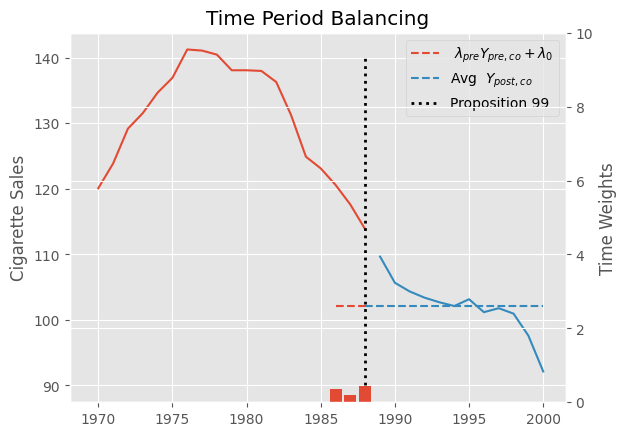

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean())
ax.plot(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean())

intercept = -15.023877689807628
ax.hlines((data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean() * time_weights).sum() - 15, 1986, 1988,
          color="C0", ls="dashed", label=""" $\lambda_{pre} Y_{pre, co} + \lambda_0$""")
ax.hlines(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean().mean(), 1988, 2000,
          color="C1", ls="dashed", label="""Avg  $Y_{post, co}$""")
ax.vlines(x=1988, ymin=90, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()

plt.title("Time Period Balancing")
plt.ylabel("Cigarette Sales");

ax2 = ax.twinx()
ax2.bar(time_weights.index, time_weights, label="$\lambda$")
ax2.set_ylim(0,10)
ax2.set_ylabel("Time Weights");

In [54]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .sort_values(year_col)
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
    pre_data = data.query(f"~{post_col}")
    
    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(year_col, state_col, outcome_col))
    
    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add a (T_pre, 1) column to the begining of the (T_pre, N_co) matrix to serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1) 
    
    # estimate unit weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)

In [55]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

unit_weights.round(3).head()

state
1   -0.000
2   -0.000
4    0.057
5    0.078
6    0.070
Name: unit_weights, dtype: float64

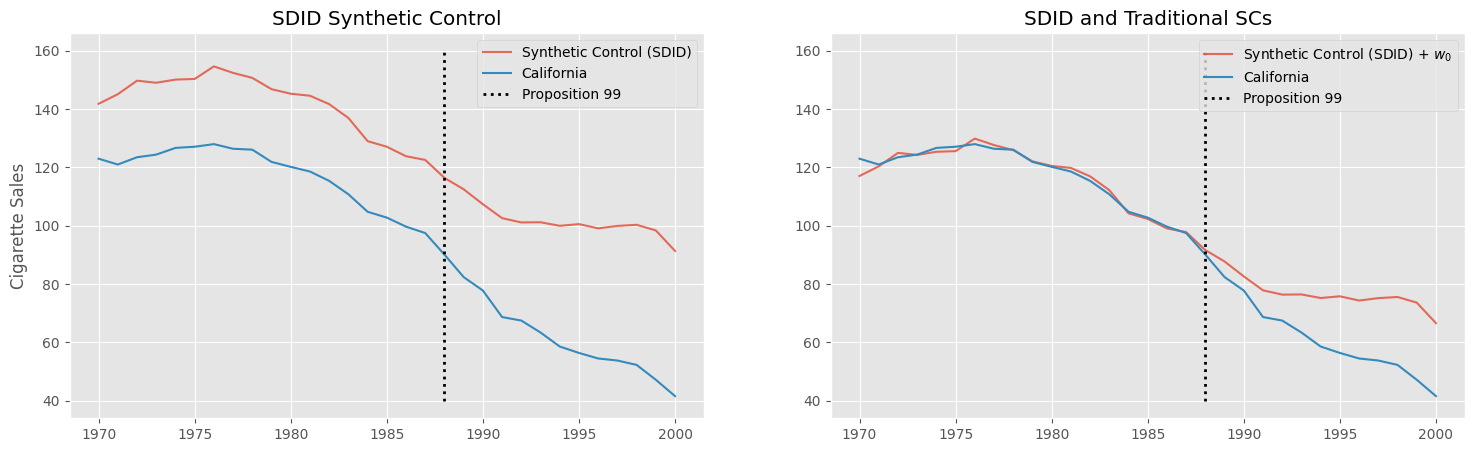

In [57]:
intercept = -24.75035353644767
sc_did = data_piv.drop(columns="california").values @ unit_weights.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=.8)
ax1.plot(data_piv["california"], label="California", color="C1")
ax1.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")

ax1.legend()
ax1.set_title("SDID Synthetic Control")
ax1.set_ylabel("Cigarette Sales");

ax2.plot(data_piv.index, sc_did+intercept, label="Synthetic Control (SDID) + $w_0$", color="C0", alpha=.8)
#ax2.plot(data_piv.index, sc, label="Traditional SC", color="C0", ls="dashed")
ax2.plot(data_piv["california"], label="California", color="C1")
ax2.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")
ax2.legend()
ax2.set_title("SDID and Traditional SCs");

In [58]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):
    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: 1 / len(pd.unique(data.query(f"{post_col}")[year_col])),
                 unit_w.name: 1 / len(pd.unique(data.query(f"{treat_col}")[state_col]))})
        .assign(**{"weights": lambda d: (d[time_w.name] * d[unit_w.name]).round(10)})
        .astype({treat_col: int, post_col: int}))

did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        state_col="state",
                        treat_col="treated",
                        post_col="after_treatment")

did_data.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600034e-14,-1.360835e-16,0.0
1,1971,1,95.400002,0,0,-4.582315e-14,-1.360835e-16,0.0
2,1972,1,101.099998,0,0,-5.274190e-14,-1.360835e-16,0.0
3,1973,1,102.900002,0,0,-5.766356e-14,-1.360835e-16,0.0
4,1974,1,108.199997,0,0,-5.617979e-14,-1.360835e-16,0.0


In [59]:
data["after_treatment"].mean(), 1/len(data.query("after_treatment==1")["year"].unique())

(0.3870967741935484, 0.08333333333333333)

In [60]:
did_model = smf.wls("cigsale ~ after_treatment*treated",
                    data=did_data,
                    weights=did_data["weights"]+1e-10).fit()

did_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4060,1.272,94.665,0.000,117.911,122.901
after_treatment,-19.1905,1.799,-10.669,0.000,-22.720,-15.661
treated,-25.2601,1.799,-14.043,0.000,-28.789,-21.731
after_treatment:treated,-15.6054,2.544,-6.135,0.000,-20.596,-10.615


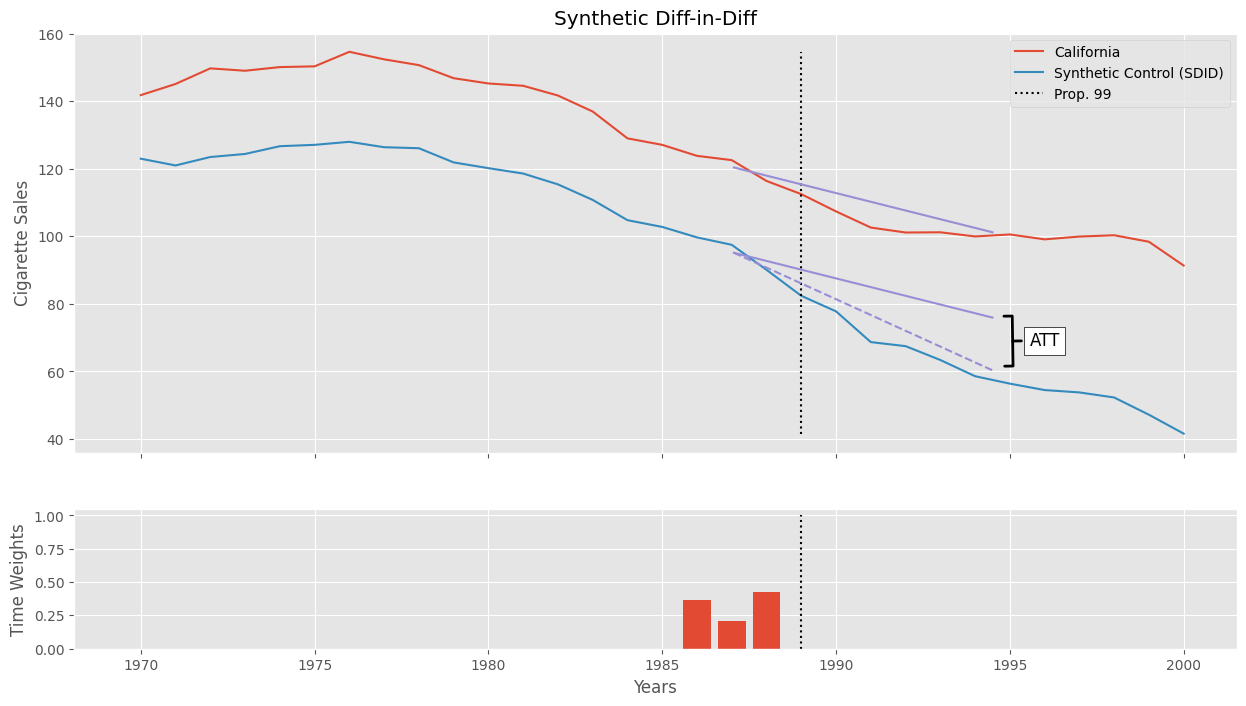

In [61]:
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, sc_did, label="California")
ax1.plot(data_piv.index, data_piv["california"], label="Synthetic Control (SDID)")
ax1.vlines(1989, data_piv["california"].min(), sc_did.max(), color="black", ls="dotted", label="Prop. 99")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["after_treatment"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["after_treatment:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")

ax1.annotate('ATT', xy=(1995, 69), xytext=(1996, 66.5), 
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=2.0, color='k'))

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff") 
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years");

In [62]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    # find the unit weights
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    # find the time weights
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    # join weights into DiD Data
    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)
    
    # run DiD
    formula = f"{outcome_col} ~ {post_col}*{treat_col}"
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    
    return did_model.params[f"{post_col}:{treat_col}"]


synthetic_diff_in_diff(data, 
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

-15.605397234587086

In [63]:
effects = {year: synthetic_diff_in_diff(data.query(f"~after_treatment|(year=={year})"), 
                                        outcome_col="cigsale",
                                        year_col="year",
                                        state_col="state",
                                        treat_col="treated",
                                        post_col="after_treatment")
           for year in range(1989, 2001)}

effects = pd.Series(effects)

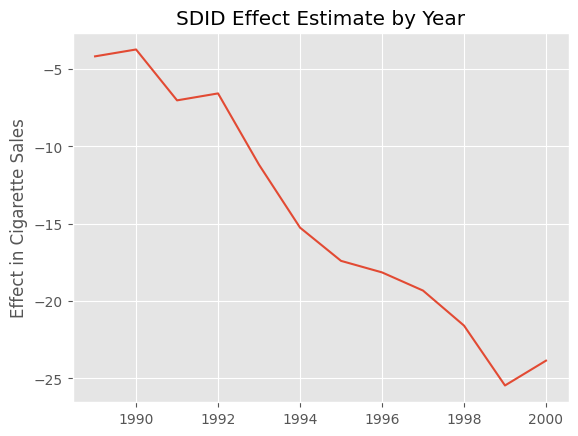

In [64]:
plt.plot(effects);
plt.ylabel("Effect in Cigarette Sales")
plt.title("SDID Effect Estimate by Year");